In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output
import time
import os
import datetime
import joblib

In [6]:
model_path = 'nn-models/nn_model_sample.keras'

try:
    loaded_model = tf.keras.models.load_model(model_path)
    print("model loaded")
    loaded_model.summary()
except Exception as e:
    print(f"model loaded failed: {e}")

scaler_path = 'nn-models/scaler.pkl'

try:
    scaler = joblib.load(scaler_path)
    print("scaler loaded")
except Exception as e:
    print(f"scaler loaded failed: {e}")


model loaded


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 779 (3.05 KB)

 Trainable params: 259 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 520 (2.04 KB)

scaler loaded


In [5]:
class Car:

    def __init__(self,car_id,init_s=0.0,init_v=0.0):
        self.id = car_id
        self.s = init_s
        self.init_s = init_s
        # displacement, save itit value for rest
        
        self.v = init_v
        self.init_v = init_v
        # velocity, save itit value for rest
        
        self.a = 0.0 
        # acceleration

        self.s_history = [self.s]
        self.v_history = [self.v]
        self.a_history = [self.a]
        # arreys to save data
    
    def reset(self):
        self.s = self.init_s
        self.v = self.init_v
        self.a = 0.0
     
        self.s_history = [self.s]
        self.v_history = [self.v]
        self.a_history = [0.0]
        # reset to initial values
        
    def set_a(self, a):
        self.a = a
        # get acceleration
        """
        accel is the system input of the auto car project
        the accel of ego car will be defined by NN
        the accels of others car will be generate by some defined rule
        for example, randomly
        """

    def step(self, dt):
        self.s += self.v*dt+0.5*self.a*dt*dt
        self.v += dt*self.a

        self.s_history.append(self.s)
        self.v_history.append(self.v)
        self.a_history.append(self.a)
        """ 
        save all history of displacement (s) and velocity (v) 
        into the arrey self.s_history and self.v_history
        """
        
        

Here's a car crash!!! 
Simulation finished.


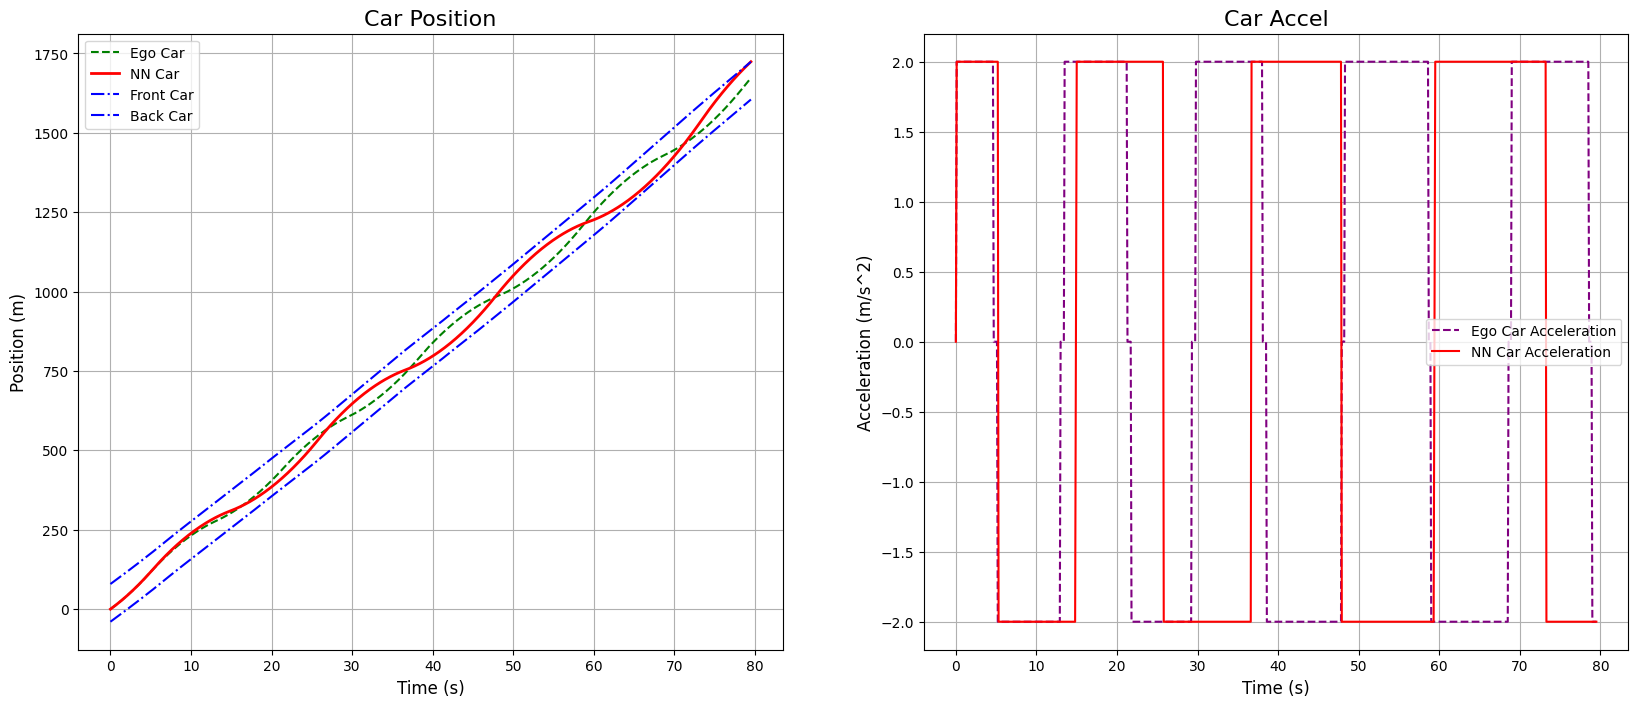

In [18]:
# def run_single_simulation(simulation_time,dt):
# np.random.seed()
np.random.seed(24)

random_gap = np.random.uniform(30,40)
random_v = np.random.uniform(15,20)

ego_car = Car(car_id="ego",init_s=0.0,init_v=random_v)
nn_car = Car(car_id="nn",init_s=0.0,init_v=random_v)
#generate ego car at initial point with random velocity

front_car = Car(car_id="front",init_s=2*random_gap,init_v=random_v)
back_car = Car(car_id="back",init_s=-random_gap,init_v=random_v)
#generate the front car and the back car as well

cars = [ego_car, front_car, back_car, nn_car]

#print(f"New cars are created!")
#print(f"The ego car is at {ego_car.s} m, with v={ego_car.v} m/s and a={ego_car.a} m/s^2")
#print(f"The front car is at {front_car.s} m, with v={front_car.v} m/s and a={front_car.a} m/s^2")
#print(f"The back car is at {back_car.s} m, with v={back_car.v} m/s and a={back_car.a} m/s^2")


simulation_time = 100.0
dt = 0.1

a_set_P = 0.2
a_set = 0.0
a_nn = 0.0
a_set_random = 0.0
a_set_max = 2.0
d_diff = 0.0
d_diff_accept = 4.0

#a_step_disterbance = 0.1


d_2_front_old = [2*random_gap]
d_2_back_old = [random_gap]
v_2_front_old = [0.0]
v_2_back_old = [0.0]

d_2_front = [2*random_gap]
d_2_back = [random_gap]
v_2_front = [0.0]
v_2_back = [0.0]

for car in cars:
    car.reset()

time_steps = np.arange(0.0,simulation_time,dt)

for k in range(len(time_steps)):
    
    """
    old ego car dynamic: 
    if closer to front -> break
    if in the middle -> stay
    if closer to back -> speed up
    """
    d_diff = d_2_front_old[-1]-d_2_back_old[-1]
    
    if np.abs(d_diff) <= d_diff_accept:
        a_set = 0.0
    else:
        a_set = np.sign(d_diff)*a_set_max
        
    ego_car.set_a(a_set)

    # new ego car (nn_car) dynamic
    current_features = np.array([[
        d_2_front[-1],
        d_2_back[-1],
        v_2_front[-1],
        v_2_back[-1]
    ]])

    scaled_features = scaler.transform(current_features)
    prediction = loaded_model.predict(scaled_features, verbose=0)
    action_class = np.argmax(prediction, axis=1)[0]

    ACTION_MAP = {
        0: -1.0,  # slow down
        1: 0.0,   # stay
        2: 1.0    # speed up
    }
    a_nn = a_set_max*ACTION_MAP[action_class]
    nn_car.set_a(a_nn)

    """
    front car and back car dynamic:
    randomly select acceleration
    """
    np.random.seed()
    a_set_random = np.random.uniform(-a_set_max,a_set_max)
    front_car.set_a(a_set_random)
    back_car.set_a(a_set_random)
    
    ego_car.step(dt)
    nn_car.step(dt)
    front_car.step(dt)
    back_car.step(dt)

    # update features
    d_2_front_old.append(front_car.s-ego_car.s)
    d_2_back_old.append(ego_car.s-back_car.s)
    v_2_front_old.append(front_car.v-ego_car.v)
    v_2_back_old.append(ego_car.v-back_car.v)

    d_2_front.append(front_car.s-nn_car.s)
    d_2_back.append(nn_car.s-back_car.s)
    v_2_front.append(front_car.v-nn_car.v)
    v_2_back.append(nn_car.v-back_car.v)

    if d_2_front_old[-1]<=0 or d_2_back_old[-1]<=0 or d_2_front[-1]<=0 or d_2_back[-1]<=0:
        print("Here's a car crash!!! ")
        break


    

print(f"Simulation finished.")

plot_time_axis = np.arange(len(ego_car.s_history))*dt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Car Position', fontsize=16)
axes[0].set_xlabel('Time (s)', fontsize=12)
axes[0].set_ylabel('Position (m)', fontsize=12)
axes[0].plot(plot_time_axis, ego_car.s_history, label='Ego Car', color='green', linestyle='--')
axes[0].plot(plot_time_axis, nn_car.s_history, label='NN Car', color='red', linewidth=2)
axes[0].plot(plot_time_axis, front_car.s_history, label='Front Car', color='blue', linestyle='-.')
axes[0].plot(plot_time_axis, back_car.s_history, label='Back Car', color='blue', linestyle='-.')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Car Accel', fontsize=16)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Acceleration (m/s^2)', fontsize=12)
axes[1].plot(plot_time_axis, ego_car.a_history, label='Ego Car Acceleration', color='purple', linestyle='--')
axes[1].plot(plot_time_axis, nn_car.a_history, label='NN Car Acceleration', color='red')
axes[1].legend()
axes[1].grid(True)
# plt.show() 

# return {
#     "d_front": d_2_front,
#     "d_back": d_2_back,
#     "v_front": v_2_front,
#     "v_back": v_2_back,
#     "ego_a": ego_car.a_history
# }
